### **Importing Required Libraries**

In [1]:
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import os

### **Loading Train Image and Test Image Data**

In [96]:
# Using the ImageDataGenerator technique to load the data

# Creating the train and test ImageDataGenerator instances
train_image_data_generator = ImageDataGenerator(
    rescale = 1/255
)

test_image_data_generator = ImageDataGenerator(
    rescale = 1/255
)

# Specifying the train directory and test directory inside a variable to use in different functions
train_directory = r'C:\Users\njain\OneDrive - Cal State Fullerton\SPRING 2024\CPSC 597 Project\Project\APMBSS\data\raw\face_detection\train'
test_directory = r'C:\Users\njain\OneDrive - Cal State Fullerton\SPRING 2024\CPSC 597 Project\Project\APMBSS\data\raw\face_detection\test'

# Loading the train data using flow_from_directory() method using `train_image_data_generator`
training_data = train_image_data_generator.flow_from_directory(
    directory = train_directory,
    target_size = (48, 48),
    batch_size = 64,
    color_mode = 'grayscale',
    class_mode = 'categorical'
)

# Loading the test data using flow_from_directory() method using `test_image_data_generator`
testing_data = test_image_data_generator.flow_from_directory(
    directory = test_directory,
    target_size = (48, 48),
    batch_size = 64,
    color_mode = 'grayscale',
    class_mode = 'categorical'
)

Found 21522 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.


### **Visualising the Images**

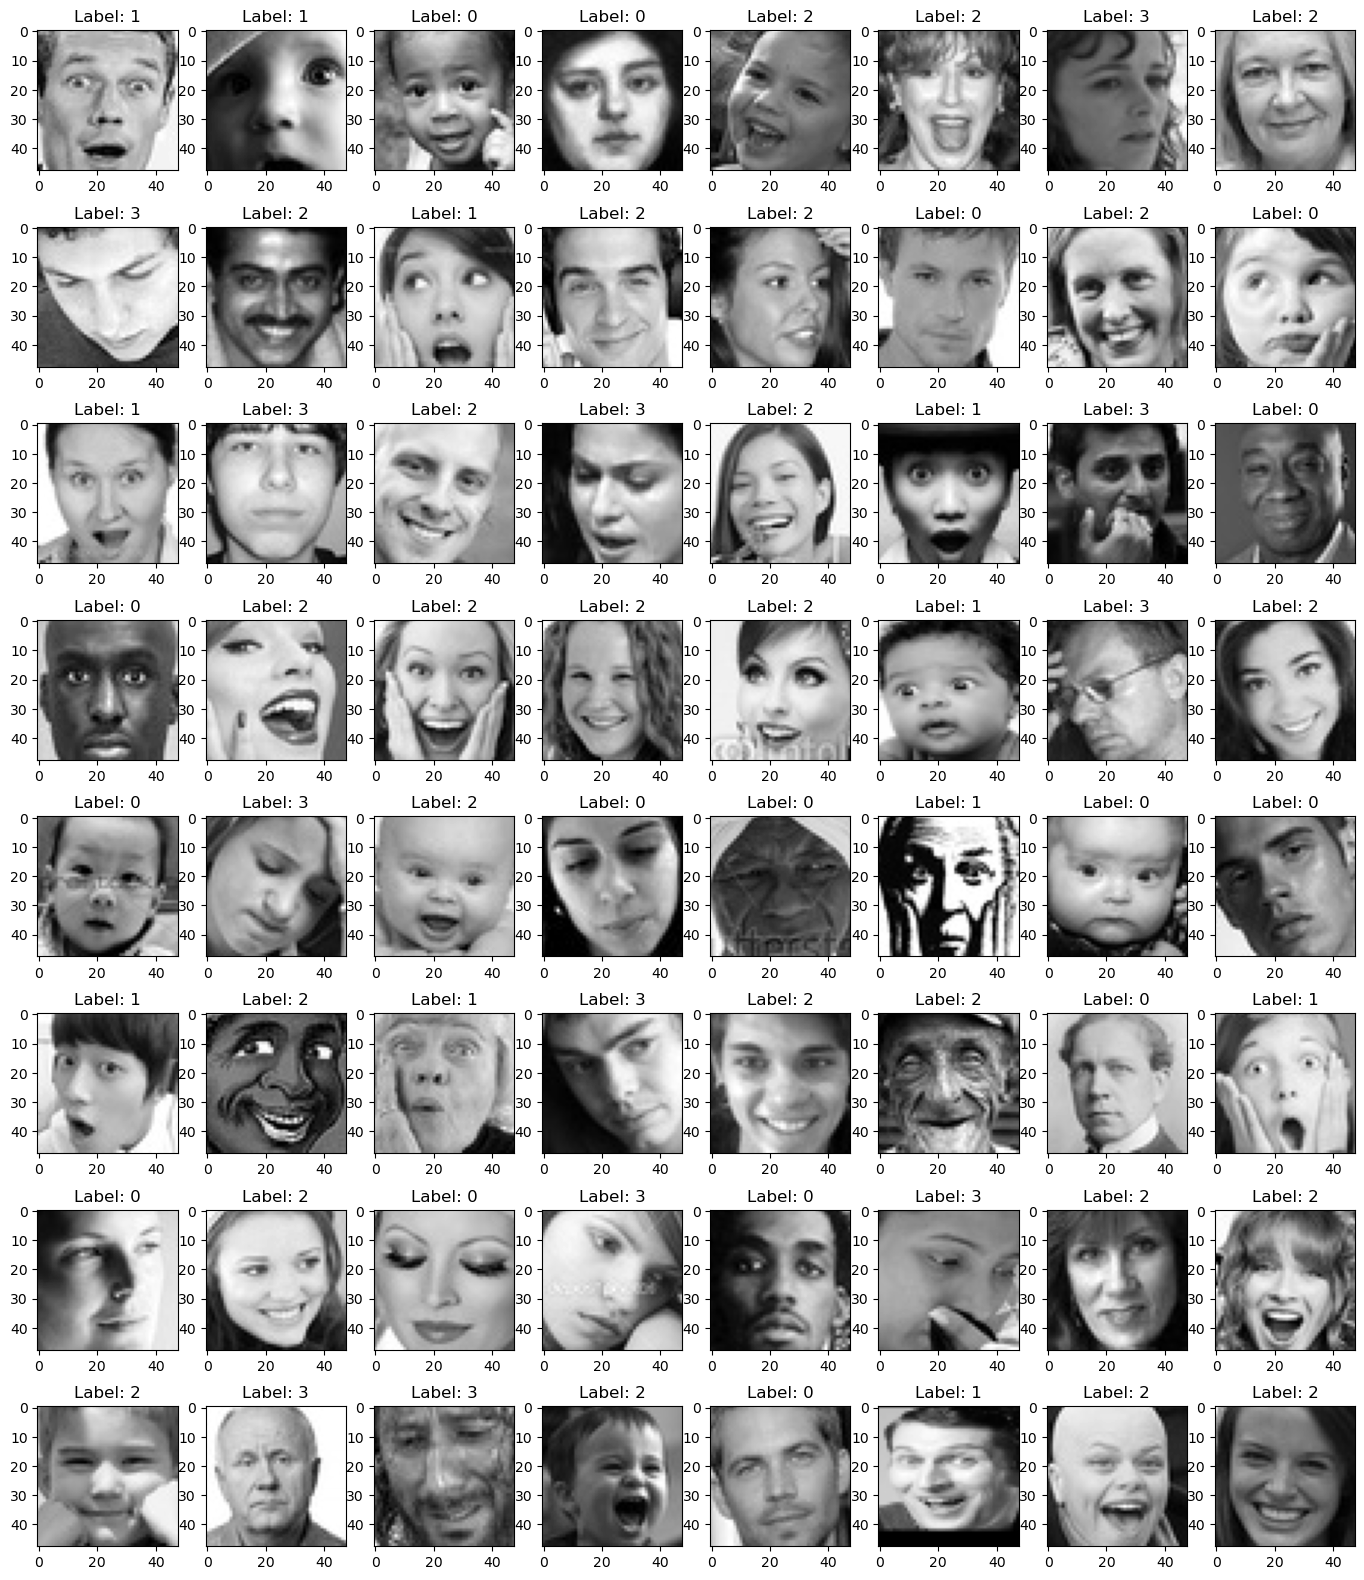

'\nBelow can be concluded from below:\nLabel 0: Calm\nLabel 1: Energetic\nLabel 2: Happy\nLabel 3: Sad\n'

In [97]:
# Getting a batch of images using next() function
sample_images, labels = next(training_data)

# Number of images to display
num_images = len(sample_images)

# Extract folder names from the generator's filenames
folder_names = [os.path.dirname(file) for file in training_data.filenames[:num_images]]

# Plotting the images using matplotlib
plt.figure(figsize =(17, 20))
for i in range(0, num_images):
    plt.subplot(8, 8, i + 1)
    plt.imshow(sample_images[i], cmap='gray')
    plt.title(f"Label: {labels[i].argmax()}")  # Display the one-hot encoded label

plt.show()

'''
Below can be concluded from below:
Label 0: Calm
Label 1: Energetic
Label 2: Happy
Label 3: Sad
'''

### **Plotting the Bar Graph Representing the Number of Items Inside the Categories Using Matplotlib**

#### **Train Data Plotting**

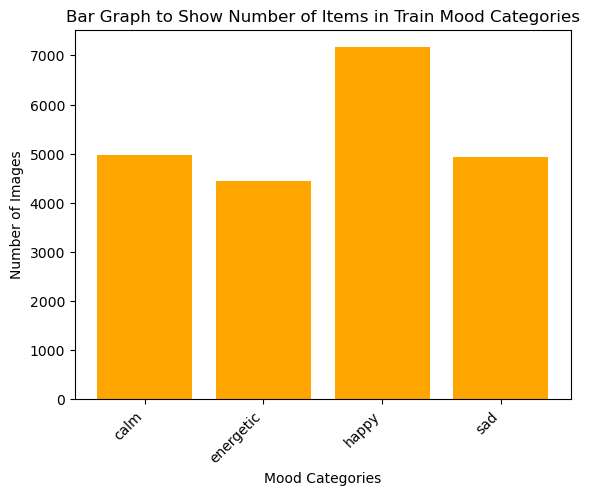

In [98]:
# Already defined the train directory path as train_directory
train_folders = [ folder for folder in os.listdir(train_directory) if os.path.isdir(os.path.join(train_directory, folder))]

folder_names_train = []
item_counts_train = []

for folder in train_folders:
    folder_path = os.path.join(train_directory, folder)
    num_items = len(os.listdir(folder_path))
    folder_names_train.append(folder)
    item_counts_train.append(num_items)

# Create a bar graph
plt.bar(folder_names_train, item_counts_train, color='orange')
plt.xlabel('Mood Categories')
plt.ylabel('Number of Images')
plt.title('Bar Graph to Show Number of Items in Train Mood Categories')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

#### **Train Data Plotting**

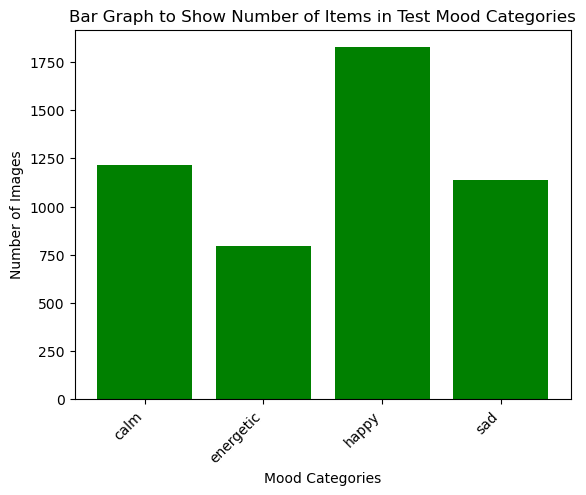

In [99]:
# Already defined the test directory path as test_directory path
test_folders = [ folder for folder in os.listdir(test_directory) if os.path.isdir(os.path.join(test_directory, folder))]

folder_names_test = []
item_counts_test = []

for folder in test_folders:
    folder_path = os.path.join(test_directory, folder)
    num_items = len(os.listdir(folder_path))
    folder_names_test.append(folder)
    item_counts_test.append(num_items)

# Create a bar graph
plt.bar(folder_names_test, item_counts_test, color='green')
plt.xlabel('Mood Categories')
plt.ylabel('Number of Images')
plt.title('Bar Graph to Show Number of Items in Test Mood Categories')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

### **Preprocessing The Data**

### **Create a CNN Model For Image Classification**

### **Training the Train Data on the CNN Image Classifier Model**

### **Testing the Test Data on the CNN Image Classifier**

### **Creating the Confusion Matrix**

### **Testing on Random Image to Check if CNN Classifier is able to Predict**